# Kepler telescope exoplanets classification

We would like to build a classification ML algorithm that can take a time series from an observation in the Kepler telescope, saying whether there is a planet or not.

The dataset is heavily skewed, since few observations were confirmed to be exoplanets. In addition, we do not want to say that we have discovered a fake exoplanet, so false positives are to be avoided at all costs!

This work was heavily inspired by https://www.kaggle.com/aleksod/0-75-precision-0-60-recall-linear-svc

In [1]:
import numpy as np;
import scipy as sci;
import csv;
import matplotlib.pyplot as plt;
from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, accuracy_score, f1_score
from scipy.signal import medfilt
import pandas as pd
import time

## Loading data

It is important to ensure that there are no null values in the data we are going to use. We check it here.

In [2]:
def dataInit():
    #Reads the .csv files in order to initialize the data
    
    PlanetTrainInfo = pd.read_csv('exoTrain.csv')
    PlanetTestInfo = pd.read_csv('exoTest.csv')
    
    return PlanetTrainInfo, PlanetTestInfo

In [3]:
PlanetTrainInfo, PlanetTestInfo = dataInit();

#We check if there are any NaNs or null values in the data
columnNamesTrain = PlanetTrainInfo.columns.values
columnNamesTest = PlanetTestInfo.columns.values
numberNanTrain = np.zeros(len(columnNamesTrain),dtype=np.uint32)
numberNanTest = np.zeros(len(columnNamesTest),dtype=np.uint32)
i = 0
for k in columnNamesTrain:
    numberNanTrain[i] = PlanetTrainInfo[k].isnull().sum()
    i += 1
i = 0
for k in columnNamesTest:
    numberNanTest[i] = PlanetTestInfo[k].isnull().sum()
    i += 1    
    
#Print the number of NaNs
print(np.sum(numberNanTrain))
print(np.sum(numberNanTest))

0
0


## How does the data look like?

We know that the Kepler exoplanets data is a time series. Probably by looking at different instances we will be able to gain some insights about what to do.

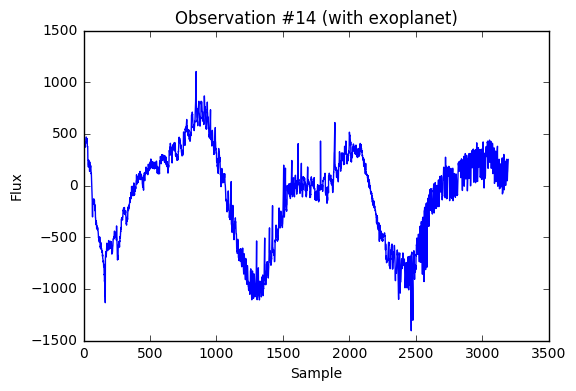

In [4]:
plt.plot(range(0,len(PlanetTestInfo.columns)-2),PlanetTrainInfo.iloc[13,2:])
plt.title('Observation #14 (with exoplanet)')
plt.xlabel('Sample')
plt.ylabel('Flux')
plt.show()

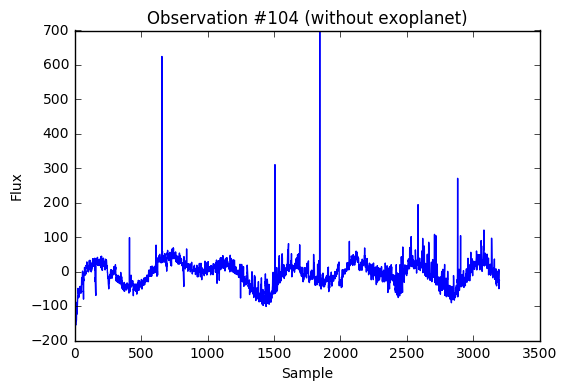

In [5]:
plt.plot(range(0,len(PlanetTestInfo.columns)-2),PlanetTrainInfo.iloc[103,2:])
plt.title('Observation #104 (without exoplanet)')
plt.xlabel('Sample')
plt.ylabel('Flux')
plt.show()

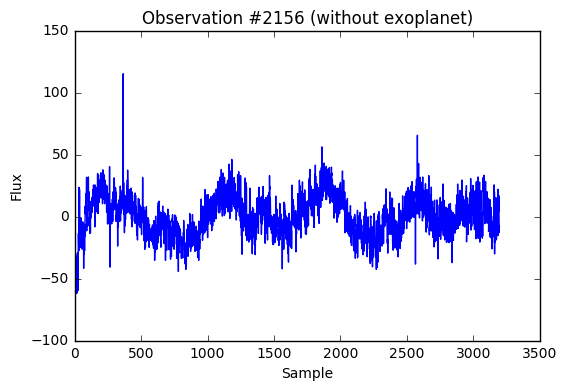

In [6]:
plt.plot(range(0,len(PlanetTestInfo.columns)-2),PlanetTrainInfo.iloc[2155,2:])
plt.title('Observation #2156 (without exoplanet)')
plt.xlabel('Sample')
plt.ylabel('Flux')
plt.show()

We see that there is a heavy periodic component here, probably due to external conditions, which makes detecting whether an object is an exoplanet or not much more difficult for our algorithms. So, we need to take out that component.

In this case, we use a median filter with 41 samples memory to take out the periodicity. It might be also of interest to see the frequency of the detrended signal, perhaps using it as a feature instead of the time series. To do that, we take Fourier transform of the detrended signal. Since the spectra of a signal is symmetric, we just take the first half of it.

Since we are interested in the relative frequency content and not the absolute strength of the frequencies, we normalize the spectra.

In [7]:
n_half = int(len(columnNamesTrain[2:])/2)

spectra_list = []

for k in range(0,len(PlanetTrainInfo)):
    sig_detrend = medfilt(PlanetTrainInfo.iloc[k,2:],41)
    xF = np.fft.fft(PlanetTrainInfo.iloc[k,2:]-sig_detrend) #Fourier Transform
    
    #We append to a list and not to a Data Frame for efficiency
    spectra_list.append(abs(xF[0:n_half])**2/max(abs(xF[0:n_half])**2))
    
    if k % 1000 == 0: #Verbosity
        print('Processed: ',k)

#Storing in DataFrame for further analysis
spectra_train = pd.DataFrame(spectra_list,columns=columnNamesTrain[2:n_half+2])

Processed:  0
Processed:  1000
Processed:  2000
Processed:  3000
Processed:  4000
Processed:  5000


In [8]:
#Same as above but for the test data. We do not need the list object anymore, so we reuse it here.

spectra_list = []

for k in range(0,len(PlanetTestInfo)):
    sig_detrend = medfilt(PlanetTestInfo.iloc[k,2:],41)
    xF = np.fft.fft(PlanetTestInfo.iloc[k,2:]-sig_detrend)
    
    spectra_list.append(abs(xF[0:n_half])**2/max(abs(xF[0:n_half])**2))
    
    if k % 100 == 0:
        print('Processed: ',k)
        
spectra_test = pd.DataFrame(spectra_list,columns=columnNamesTest[2:n_half+2])

Processed:  0
Processed:  100
Processed:  200
Processed:  300
Processed:  400
Processed:  500


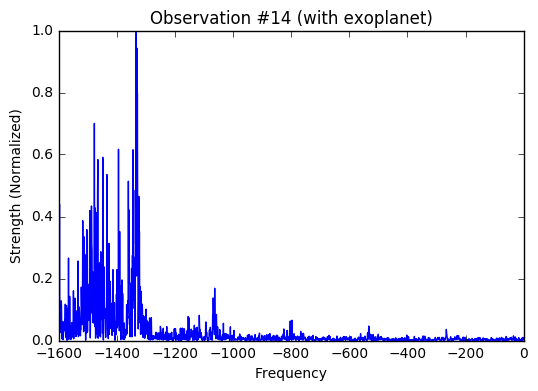

In [13]:
plt.plot(range(-len(spectra_train.columns),0),spectra_train.iloc[13,:])
plt.title('Observation #14 (with exoplanet)')
plt.xlabel('Frequency')
plt.ylabel('Strength (Normalized)')
plt.show()

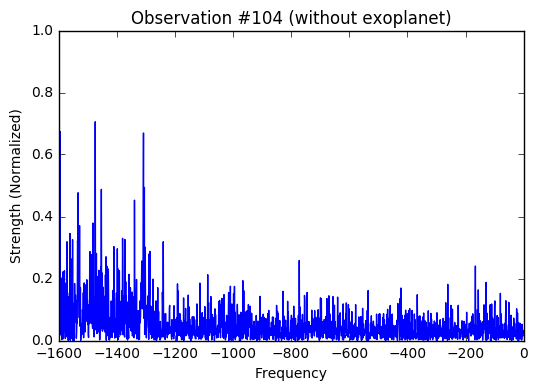

In [14]:
plt.plot(range(-len(spectra_train.columns),0),spectra_train.iloc[103,:])
plt.title('Observation #104 (without exoplanet)')
plt.xlabel('Frequency')
plt.ylabel('Strength (Normalized)')
plt.show()

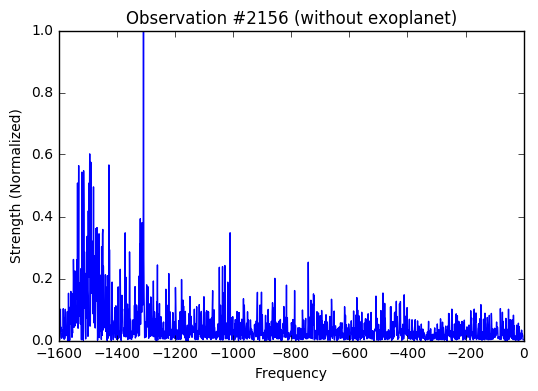

In [15]:
plt.plot(range(-len(spectra_train.columns),0),spectra_train.iloc[2155,:])
plt.title('Observation #2156 (without exoplanet)')
plt.xlabel('Frequency')
plt.ylabel('Strength (Normalized)')
plt.show()

We can see from this examples that when there is an exoplanet, there seems to be a higher content in the left side of the spectrum.

## Predictor Design and Results

A first try will be with a Logistic Regression model. It will use stratified cross validation. Scoring will be chosen as F1 instead of accuracy due to the high skewdness of the data.

In [16]:
#We normalize the labels to 0, 1 instead of 1, 2
labels_train = PlanetTrainInfo.iloc[:,1]-1
labels_test = PlanetTestInfo.iloc[:,1]-1

regLogistic = linear_model.LogisticRegressionCV(n_jobs=2, scoring='f1')
regLogistic.fit(spectra_train, labels_train) #Fit the model
print(regLogistic.scores_) #Print the scores

#Predict labels
labels_train_predicted = regLogistic.predict(spectra_train)
labels_test_predicted = regLogistic.predict(spectra_test)

#Print the metrics for both training and test sets
print('Training set metrics:\n')

print('Accuracy: ', accuracy_score(labels_train,labels_train_predicted))
print('Precision: ', precision_score(labels_train,labels_train_predicted))
print('F1: ', f1_score(labels_train,labels_train_predicted))

print('Test set metrics:\n')

print('Accuracy: ', accuracy_score(labels_test,labels_test_predicted))
print('Precision: ', precision_score(labels_test,labels_test_predicted))
print('F1: ', f1_score(labels_test,labels_test_predicted))

{1: array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.26666667,
         0.375     ,  0.55555556,  0.63157895,  0.63157895,  0.57142857],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.28571429,
         0.58823529,  0.58823529,  0.63157895,  0.6       ,  0.6       ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.15384615,
         0.5       ,  0.5       ,  0.5       ,  0.47058824,  0.55555556]])}
Training set metrics:

Accuracy:  1.0
Precision:  1.0
F1:  1.0
Test set metrics:

Accuracy:  0.99649122807
Precision:  1.0
F1:  0.75


Pretty good! We get an F1 of 0.75 and a precision of 1. That means we have no false positives! (although there will be false negatives) Let's print the results in the test set to confirm that fact!

In [18]:
print(labels_test_predicted)

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

We see that only the first three were classified as exoplanets. There are two more exoplanets that were classified as negative, unfortunately.

## Future work

* Building other models (SVM, Neural Networks...)
* Ensemble methods?
* Other filters